## Xception

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)
    
from IPython.display import Image

In [3]:
num_classes = 1000
input_shape = [299, 299, 3]

batch_size = 16
num_epochs = 10

In [4]:
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, \
                                    Dense, Flatten, Activation
from tensorflow.keras import Input, Model

### Convolution Batch-normalization block

In [5]:
def conv_bn(filters, kernel_size, strides=1, padding='valid', groups=1, name=None):
    def layer_fn(x):
        x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding=padding,
                  groups=groups,
                  use_bias = False,
                  name=name)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x
    return layer_fn

## Simplified Inception module

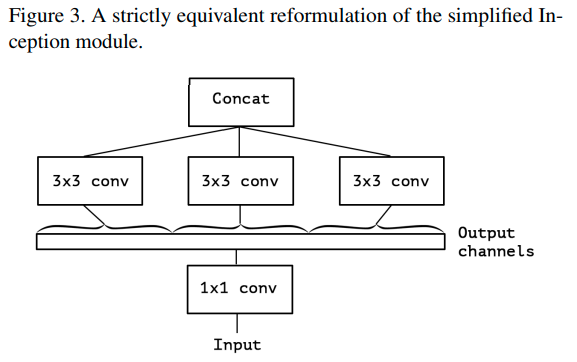

In [6]:
Image('image/xception_fig3.png')

In [7]:
def simplified_inception(filters):
    def layer_fn(x):
        x = conv_bn(filters=filters,
                  kernel_size=(1, 1))(x)
        x = conv_bn(filters=filters,
                  kernel_size=(3, 3),
                  padding='same',
                  groups=3, name='3x3_conv')(x)
        return x
    return layer_fn

### Conv2D groups 테스트
* grouped_model 은 groups=3 설정으로 생성하고, ungrouped 은 groups=1 인 일반적인 Conv2D 로 생성했을 때 파라미터를 비교

In [8]:
def grouped_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = simplified_inception(32*3)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [9]:
def ungrouped_conv(filters):
    def layer_fn(x):
        x = conv_bn(filters=filters,
                  kernel_size=(1, 1))(x)
        x = conv_bn(filters=filters,
                  kernel_size=(3, 3),
                  padding='same',
                  groups=1, name='3x3_conv')(x)
        return x
    return layer_fn

In [10]:
def ungrouped_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = ungrouped_conv(32*3)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [11]:
num_classes = 10
input_shape = [32, 32, 3]

batch_size = 16

In [12]:
batch_input_shape = tf.TensorShape((None, *input_shape))

In [13]:
model = grouped_model(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 96)        288       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 96)       384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 96)        0         
                                                                 
 3x3_conv (Conv2D)           (None, 32, 32, 96)        27648     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 96)       384       
 hNormalization)                                             

In [14]:
model = ungrouped_model(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 96)        288       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 96)       384       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 32, 32, 96)        0         
                                                                 
 3x3_conv (Conv2D)           (None, 32, 32, 96)        82944     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 96)       384       
 hNormalization)                                           

* ungrouped_model 의 3x3_conv 레이어의 파라미터 수는 82944
* grouped_model 의 3x3_conv 레이어의 파라미터 수는 27648

grouped_model 이 정확히 1/3 배의 파라미터수를 가지는 것으로 보아 3 개의 group 으로 정상적으로 작동함을 확인할 수 있었습니다. 

## Extreme version Inception module

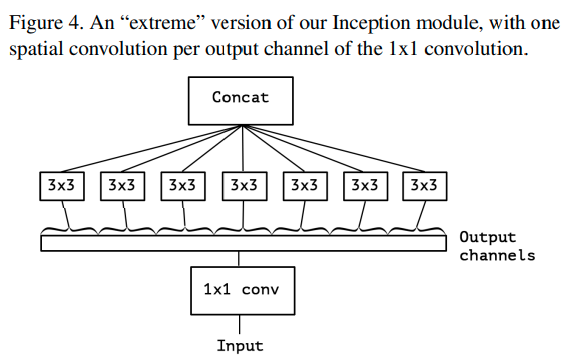

In [15]:
Image('image/xception_fig4.png')

In [16]:
def extreme_inception(filters):
    def layer_fn(x):
        x = conv_bn(filters=filters,
                  kernel_size=(1, 1), name='1x1_conv')(x)
        x = conv_bn(filters=filters,
                  kernel_size=(3, 3),
                  padding='same',
                  groups=filters, name='extreme')(x)
        return x
    return layer_fn

In [17]:
def extreme_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = extreme_inception(32)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [18]:
num_classes = 10
input_shape = [32, 32, 3]

batch_size = 16

In [19]:
batch_input_shape = tf.TensorShape((None, *input_shape))

In [20]:
model = extreme_model(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 1x1_conv (Conv2D)           (None, 32, 32, 32)        96        
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 extreme (Conv2D)            (None, 32, 32, 32)        288       
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                           

extreme 레이어의 파라미터 수 288 은

1개의 채널마다 3x3 conv 연산을 개별적으로 진행한 결과이므로

9(# of kernel param) * 32(# of in_channel) * 1(# of out_channel)

로 계산됩니다.

## Depth-wise Separable Convolution

In [21]:
def conv_separable(filters):
    def layer_fn(x):
        x = SeparableConv2D(filters=filters,
                           kernel_size=(3,3),
                           strides=1,
                           padding="same",
                           depth_multiplier=1,
                           use_bias=False,
                           name='separable_conv')(x)
        x = BatchNormalization()(x)
        return x
    return layer_fn

In [22]:
def separable_model(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = conv_separable(32)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [23]:
model = separable_model(input_shape, num_classes)
model.build(input_shape=batch_input_shape)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 separable_conv (SeparableCo  (None, 32, 32, 32)       123       
 nv2D)                                                           
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 output (Dense)              (None, 10)                327690    
                                                                 
Total params: 327,941
Trainable params: 327,877
Non-trainab

separable_conv 레이어의 파라미터 수 123 은

3x3 depthwise spatial convolution 연산 후

pointwise convolution 연산의 결과이므로

9(# of kernel param) * 3(# of in_channel) +
3(# of in_channel) * 1(# of kernel param) * 32(# of out_channel)

로 계산됩니다.

## Depth-wise Separable VS Extreme Inception
* 두 연산 모두 channel-wise spatial convolution 과 1x1 convolution 을 수행하지만 작동 순서가 다릅니다.
    * Depth-wise Separable : channel-wise conv -> 1x1 conv
    * Extreme Inception : 1x1 conv -> channel-wise conv
* 첫 연산 이후에 비선형성 존재에 따른 차이가 있습니다.
    * Depth-wise Separable : 첫 연산 이후에 비선형성을 위한 연산이 존재하지 않습니다.
    * Extreme Inception : 두 연산 뒤에는 항상 ReLU 비선형성이 따라옵니다.

## Xception architecture
* 주요 가정 : convolutional neural networks 의 feature map 에서 채널 간 상관 관계와 공간 상관 관계 매핑은 완전히 분리 가능하다.
* 이러한 가정을 기반으로 Xception 는 depth-wise separable convolution 을 사용하여 cross-channel conv과 spatial conv 를 독립적으로 계산하도록 고안되었습니다.

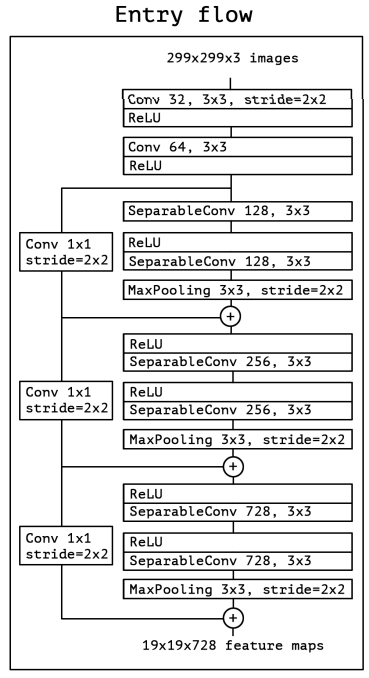

In [24]:
Image('image/xception_entry_flow.png')

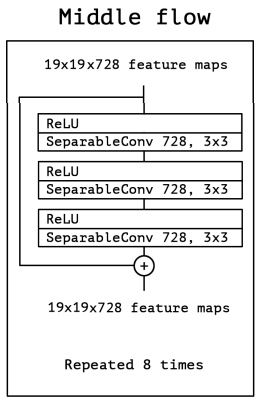

In [25]:
Image('image/xception_middle_flow.png')

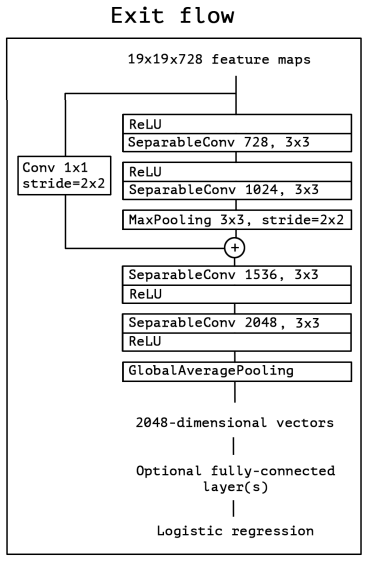

In [26]:
Image('image/xception_exit_flow.png')